In [3]:
try:
    import numpy as np 
    from matplotlib import pyplot as plt

    import scipy.misc
    from scipy import ndimage

    import skimage as sk

    from PIL import Image 
    from PIL.ExifTags import TAGS, GPSTAGS

    from ALP4 import *
    import time

    print('Succesfully import of packages.')
except:
    print('Error importing packages.')
    

Succesfully import of packages.


In [4]:
resX = 1024;
resY = 768;
P0 = 0.5; 
sigX = 146;
sigY = sigX; 

x = np.arange(-resX/2,resX/2);   
y = np.arange(-resY/2,resY/2);
n = 8;

apRad = 40;
space = 15;
light_shift_coord_x = 4;
light_shift_coord_y = 4;

angle = 45;
mesh = np.meshgrid(x,y);

radius = 200.0;
origin = [int(0), int(0)];

ref_im = 'refim.png';

ringPat = np.zeros((resY, resX), dtype = int);
sepsit = np.zeros((resY, resX), dtype = int);
RoDp = np.zeros((resY, resX), dtype = int);
diskp = np.zeros((resY, resX), dtype = int);

profile = [ 2, 4, 6, 160, 200, 250, 300];#, 400, 600, 800, 1000, 1200]; #try to follow profile from .py
gap = 2;

In [76]:
def saveIm(imagen, namef='image.png' ):
    scipy.misc.toimage(imagen, cmin=0, cmax=1).save(namef);

def Im2bin(pat, namef='image.png'):
    npat = pat.astype('bool');
    return npat

def site(mesh, i, j, pat):
        pat[np.logical_and(np.abs(mesh[0]-j) < apRad/2, np.abs(mesh[1]-i) < apRad/2)] = 1;

def ring(center, radius, nr):

    xpos = [];
    ypos = [];

    ang = 2*np.pi/nr;
    origin = center;

    for i in range(nr):
        x, y = [int(radius*np.cos(ang*i)) + origin[0], int(radius*np.sin(ang*i))+origin[1]];
        xpos.append(x) ; ypos.append(y);
    return xpos, ypos, origin

def RingPattern(mesh, xpos, ypos, pat):

    for i, j in zip(xpos, ypos):
        Osite(mesh, i, j, pat);

    bpatBW = Im2bin(pat); #It seems DMD doesn't with this format only
    dummie = sk.img_as_bool(bpatBW); #to a boolean

    return dummie

def dmd_prep(refim, finalim, fname, angval=0, mode=False):

    pic1 = refim;	#reference image for extract the palette
    pic2 = finalim;	#image to be save

    image1 = Image.open(pic1);
    image2 = Image.open(pic2);

    pal1=image1.getpalette() #getting palette
    image2.putpalette(pal1)	 #assigning the reference palette in the final image's palette

    if angval != 0:
        image2 = imcrop(image2, (resX,resY));

    image2.save(fname + ".PNG", dpi=(72,72), bits=1);

def Osite(mesh, i, j, pat):
        pat[np.logical_and( np.abs( (mesh[0]-j)**2 ) < apRad/2 - np.abs((mesh[1]-i)**2) , np.abs( (mesh[1]-i)**2 ) < apRad/2 - np.abs( (mesh[0]-j)**2 ))] = 1;

def OsiteDif(mesh, i, j, pat, val, apRad):
        pat[np.logical_and( np.abs( (mesh[0]-j)**2 ) < apRad/2 - np.abs((mesh[1]-i)**2) , np.abs( (mesh[1]-i)**2 ) < apRad/2 - np.abs( (mesh[0]-j)**2 ))] = val;

def disk(mesh, center, pat, profile, gap):
    #copy of the original pattern to be modify
    npat = np.copy(pat);

    rad1 = [center[0]];
    rad2 = [center[1]];

    #for loop for the creation of the different rings
    for j in range(len(profile)):

        r2j = float(rad1[int(j)]) + float(profile[int(j)]);
        rad2.append(r2j);

        r1jj = float(rad2[int(j)]) + float(gap)*0.3;
        rad1.append(r1jj);

        value = 0;

        for i in rad1[::-1]:
            value = (value+1)%2;
            Rad = i*2;
            circ = OsiteDif(mesh, 0, 0, pat, value, Rad);

    #getting bin image of pattern
    bpatBW = Im2bin(pat); #It seems DMD doesn't with this format only
    # bpat = sk.color.grey2rgb(rpat); #In case RGB format is need
    dummie = sk.img_as_bool(bpatBW);

#$#
def disk2(mesh, center, pat, profile, gap):
    #copy of the original pattern to be modify
    npat = np.copy(pat);
    
    #setting inner and external radius structures
    r = [center[0]];
    R = [center[1]];
    
    #value for the pixel 0 or 1
    value = 0;

#     profile = [ 12, 20, 35, 60, 90, 120];#, 160, 200, 250, 300,400, 600, 800, 1000, 1200]; #try to follow profile from .py

    #for loop for the creation of the different rings
    for j in range(len(profile)):

        Rj = r[int(j)] + profile[int(j)];
        R.append(Rj);

        rjj = R[int(j)] + float(gap);
        r.append(rjj);
        
#         print(Rj, rjj)
        
        for i in r[::-1]:
            value = (value+1)%2;
            Rad = i*2;
            print(i)
            circ = OsiteDif(mesh, center[0], center[1], pat, value, Rad);
            plt.figure()
            plt.imshow(pat)
            plt.show()
            plt.close()
    print(r,R)
    
    #getting bin image of pattern
    bpatBW = Im2bin(pat); #It seems DMD doesn't with this format only
    # bpat = sk.color.grey2rgb(rpat); #In case RGB format is need
    dummie = sk.img_as_bool(bpatBW);
    
#$#
def ringOfDisks(mesh, center, radius, n, RoDpat, profile, gap):
    xpos, ypos, origin = ring(center, radius, n);

    for i, j in zip(xpos, ypos):
#         print(i,j)
        disk2(mesh, [i,j], RoDpat, profile, gap)

    bpatBW = Im2bin(RoDpat); #It seems DMD doesn't with this format only
    dummie = sk.img_as_bool(bpatBW); #to a boolean

    return dummie

In [77]:
# RoD = ringOfDisks(mesh, origin, radius, n, RoDp, profile, gap)

In [78]:
# plt.figure()
# plt.imshow(RoD)
# plt.grid(b=None, which='both', axis='both')
# # plt.xlim(right=400,left=800)  # adjust the right leaving left unchanged
# # plt.ylim(top=300,bottom=600) 
# plt.show()
# plt.savefig('output.png', dpi=300, bbox_inches='tight')

202.0


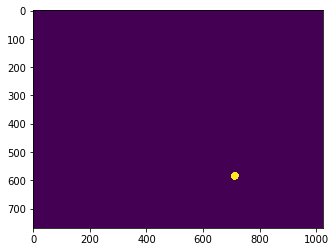

200


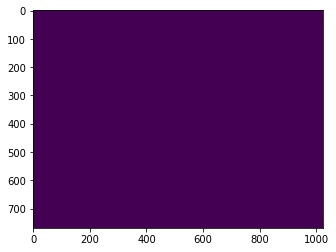

204.0


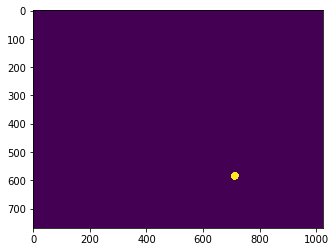

202.0


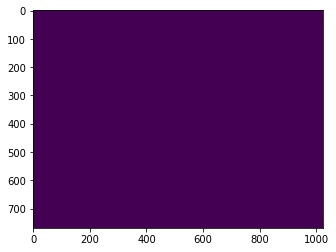

200


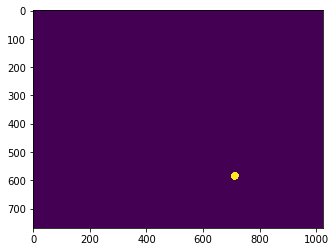

208.0


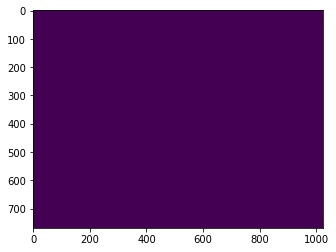

204.0


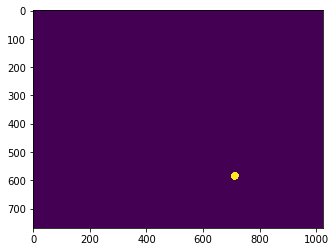

202.0


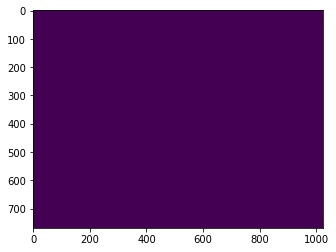

200


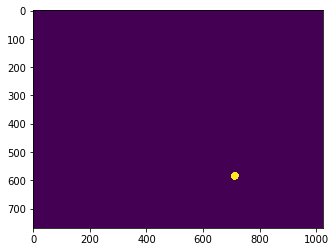

212.0


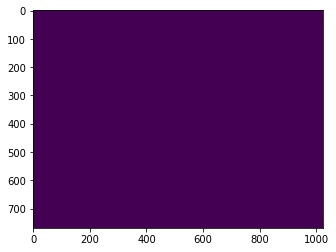

208.0


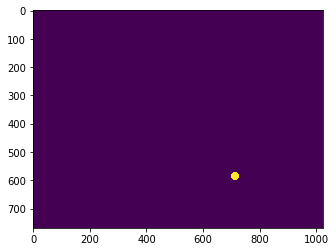

204.0


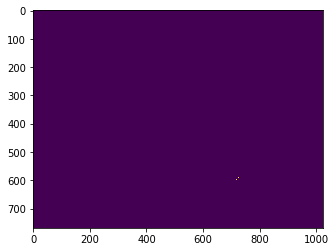

202.0


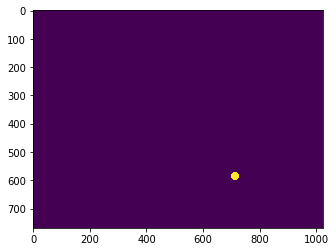

200


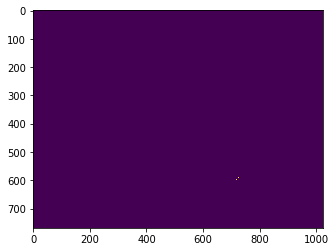

370.0


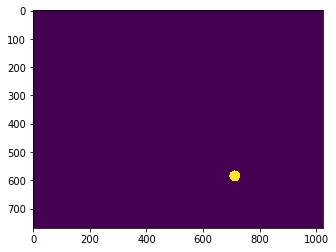

212.0


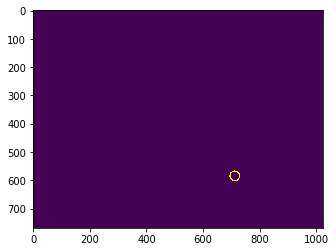

208.0


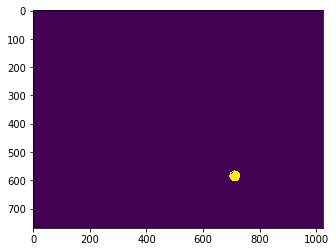

204.0


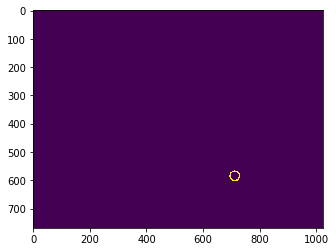

202.0


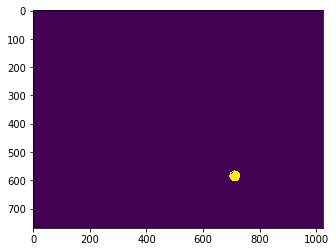

200


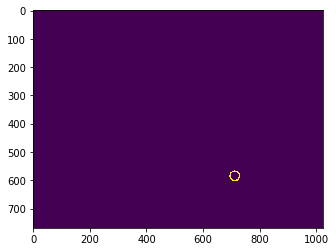

414.0


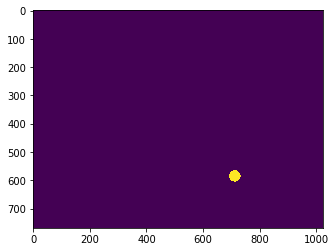

370.0


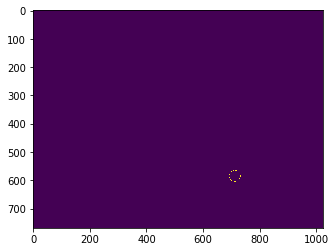

212.0


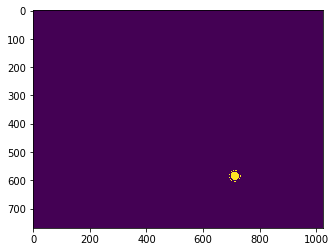

208.0


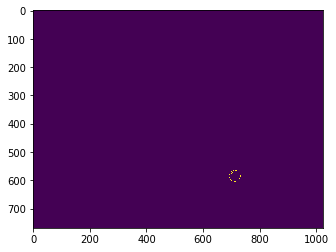

204.0


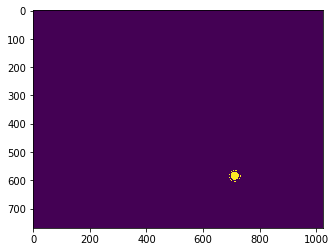

202.0


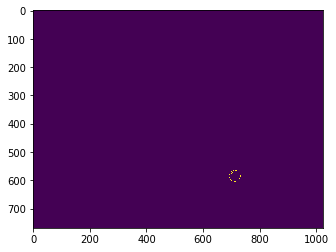

200


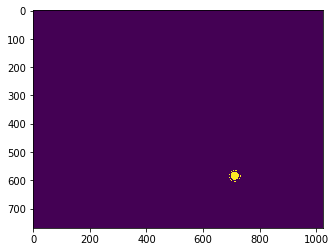

622.0


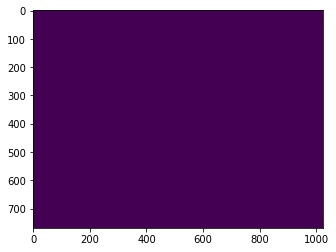

414.0


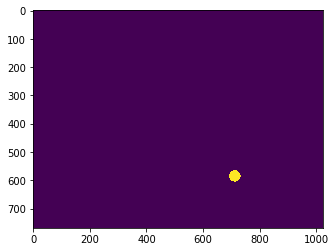

370.0


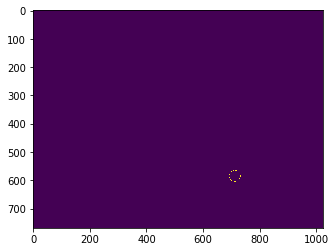

212.0


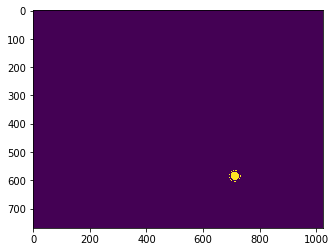

208.0


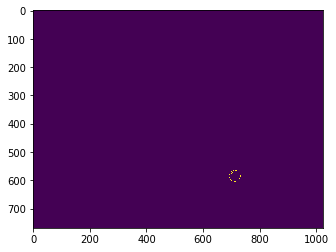

204.0


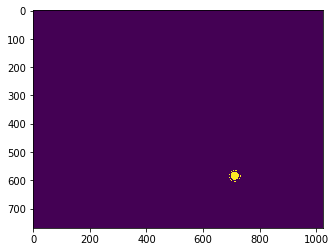

202.0


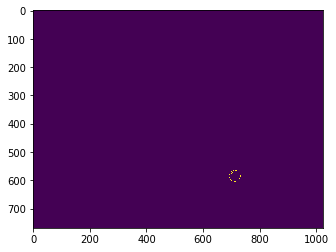

200


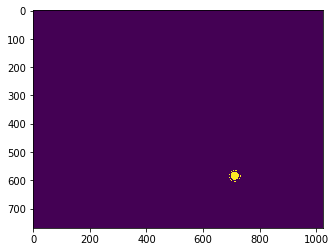

[200, 202.0, 204.0, 208.0, 212.0, 370.0, 414.0, 622.0] [200, 202, 206.0, 210.0, 368.0, 412.0, 620.0, 714.0]


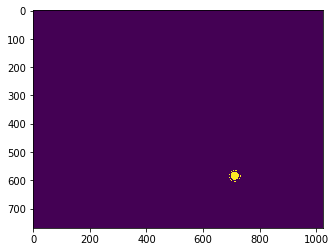

In [79]:
RoD = np.zeros((resY, resX), dtype = int);
'''200 0
141 141
0 200
-141 141
-200 0
-141 -141
0 -200
141 -141'''
#     profile = [ 12, 20, 35, 60, 90, 120];#, 160, 200, 250, 300,400, 600, 800, 1000, 1200]; #try to follow profile from .py
disk2(mesh, [200,200], RoD, profile, gap)
plt.imshow(RoD)
# plt.xlim(right=800,left=600)  # adjust the right leaving left unchanged
# plt.ylim(top=650, bottom=550) 

In [ ]:
diskpat = disk2(mesh, [100,100], diskp, profile, gap);

In [ ]:
plt.figure()
plt.imshow(diskp)
plt.grid(b=None, which='both', axis='both')
# plt.xlim(right=400,left=800)  # adjust the right leaving left unchanged
# plt.ylim(top=300,bottom=600) 
plt.show()